# Setup 

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8e528a5e-b498-493f-81ba-bf7be85d6b9f;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 448ms :: artifacts dl 57ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/29 15:05:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [4]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("ReadS3Parquet").getOrCreate()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-711387073580
23/11/29 15:05:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import avg
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import count

# Data

In [6]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_comments = spark.read.parquet(s3_directory)

23/11/29 15:05:45 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
# S3 directory path
s3_directory = f"s3a://{bucket}/project/cleaned/submissions/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions = spark.read.parquet(s3_directory)

23/11/29 15:05:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Importing Data for other Subreddits 

In [9]:
# Tegveer subreddits
tegveer_bucket = 'sagemaker-us-east-1-433974840707'
s3_directory_tegveer = f"s3a://{tegveer_bucket}/project/cleaned/submissions/"
s3_directory_tegveer_comments = f"s3a://{tegveer_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_centrist_liberterian = spark.read.parquet(s3_directory_tegveer)
df_comments_centrist_liberterian = spark.read.parquet(s3_directory_tegveer_comments)


In [10]:
# Eric subreddits
eric_bucket = 'sagemaker-us-east-1-395393721134'
s3_directory_eric = f"s3a://{eric_bucket}/project/cleaned/submissions/"
s3_directory_eric_comments = f"s3a://{eric_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_socialism_economics = spark.read.parquet(s3_directory_eric)
df_submissions_socialism_economics_comments = spark.read.parquet(s3_directory_eric_comments)

In [11]:
# Raunak subreddits

raunak_bucket = 'sagemaker-us-east-1-224518912016'
s3_directory_raunak = f"s3a://{raunak_bucket}/project/cleaned/submissions/"
s3_directory_raunak_comments = f"s3a://{raunak_bucket}/project/cleaned/comments/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions_conservative_finance = spark.read.parquet(s3_directory_raunak)
df_submissions_conservative_finance_comments = spark.read.parquet(s3_directory_raunak_comments)

In [12]:
# My subreddits 

df_submissions_askpol_cmv = df_submissions.filter(df_submissions['subreddit'].isin(['changemyview', 'Ask_Politics']))

In [13]:
# Joining all the dataframes 

combined_df = (df_submissions_centrist_liberterian
               .union(df_submissions_socialism_economics)
               .union(df_submissions_conservative_finance)
               .union(df_submissions_askpol_cmv))

combined_df.count()

599908

In [15]:
# Keep relevant columns for the regression

from pyspark.sql.functions import length

df = combined_df.select('title' , 'selftext', 'subreddit' , 'score' , 'num_comments' , 'is_video' , 'spoiler' , 
'over_18' )

df = df.withColumn('title_length', length(df['title']))

df.show()


+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|               title|            selftext|  subreddit|score|num_comments|is_video|spoiler|over_18|title_length|
+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|I swear, people p...| Fookin libertarians|Libertarian|   38|         167|   false|  false|  false|         104|
|Is it abortion bl...|I personally beli...|Libertarian|    0|         590|   false|  false|  false|          47|
|What are your tho...|[https://www.vox....|Libertarian|    0|          51|   false|  false|  false|         114|
|9 Reasons Why Fed...|                    |Libertarian|    5|           1|   false|  false|  false|          61|
|Economics and Ethics|                    |Libertarian|    7|           4|   false|  false|  false|          20|
|What do you think...|                    |   centrist|    3|           5|   false|  false|  fal

### ML

In [16]:
from pyspark.sql.functions import length, col
from pyspark.sql import SparkSession
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

# Drop NA from all the dataset
df = df.dropna()

In [17]:
df.show()

+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|               title|            selftext|  subreddit|score|num_comments|is_video|spoiler|over_18|title_length|
+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|I swear, people p...| Fookin libertarians|Libertarian|   38|         167|   false|  false|  false|         104|
|Is it abortion bl...|I personally beli...|Libertarian|    0|         590|   false|  false|  false|          47|
|What are your tho...|[https://www.vox....|Libertarian|    0|          51|   false|  false|  false|         114|
|9 Reasons Why Fed...|                    |Libertarian|    5|           1|   false|  false|  false|          61|
|Economics and Ethics|                    |Libertarian|    7|           4|   false|  false|  false|          20|
|What do you think...|                    |   centrist|    3|           5|   false|  false|  fal

In [18]:
# Sample from dataframe for preliminary testing

sampled_df = df.sample(withReplacement=False, fraction=0.2)

sampled_df.show()


+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|               title|            selftext|  subreddit|score|num_comments|is_video|spoiler|over_18|title_length|
+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+
|Is it abortion bl...|I personally beli...|Libertarian|    0|         590|   false|  false|  false|          47|
|What are your tho...|[https://www.vox....|Libertarian|    0|          51|   false|  false|  false|         114|
|Social Media Cens...|It is likely that...|Libertarian|    2|          12|   false|  false|  false|          65|
|Reporter Forcibly...|                    |   centrist|   67|         213|   false|  false|  false|          47|
|Trump supporters ...|           [deleted]|Libertarian|  317|         288|   false|  false|  false|          60|
|     My condolences.|                    |Libertarian|    0|           2|   false|  false|  fal

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_index")
subreddit_encoder = OneHotEncoder(inputCol="subreddit_index", outputCol="subreddit_vec")


pipeline = Pipeline(stages=[subreddit_indexer, subreddit_encoder])

df_encoded = pipeline.fit(df).transform(df)

df_encoded = df_encoded.withColumn("is_video", col("is_video").cast("integer"))
df_encoded = df_encoded.withColumn("spoiler", col("spoiler").cast("integer"))
df_encoded = df_encoded.withColumn("over_18", col("over_18").cast("integer"))

# Show the result
df_encoded.show()

+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+---------------+-------------+
|               title|            selftext|  subreddit|score|num_comments|is_video|spoiler|over_18|title_length|subreddit_index|subreddit_vec|
+--------------------+--------------------+-----------+-----+------------+--------+-------+-------+------------+---------------+-------------+
|I swear, people p...| Fookin libertarians|Libertarian|   38|         167|       0|      0|      0|         104|            2.0|(8,[2],[1.0])|
|Is it abortion bl...|I personally beli...|Libertarian|    0|         590|       0|      0|      0|          47|            2.0|(8,[2],[1.0])|
|What are your tho...|[https://www.vox....|Libertarian|    0|          51|       0|      0|      0|         114|            2.0|(8,[2],[1.0])|
|9 Reasons Why Fed...|                    |Libertarian|    5|           1|       0|      0|      0|          61|            2.0|(8,[2],[1.0])|

### Linear Regression

In [28]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Combine all features into a single vector
assembler = VectorAssembler(
    inputCols=["is_video", "spoiler", "over_18", "title_length", "subreddit_vec"],
    outputCol="assembled_features")

# Normalize the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")

# Define the Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets (80-20 split)
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)


23/11/29 16:04:57 WARN Instrumentation: [493c4d56] regParam is zero, which might cause numerical instability and overfitting.


R-squared on test data = 0.00524441


### Random Forest

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Combine all features into a single vector
assembler = VectorAssembler(
    inputCols=["is_video", "spoiler", "over_18", "title_length",  "subreddit_vec"],
    outputCol="features")

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="score")

# Define the Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets (80-20 split)
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)


R-squared on test data = 0.00758535


## Analysis

In [33]:
# Convert spark df to pandas 

df_encoded_pd = df_encoded.toPandas()

In [47]:
# Sample for the sake of visualizations (statistical distirbutions should be representative of all rows)
# Sample 10% of the rows without replacement

sampled_df = df_encoded_pd.sample(frac=0.1, replace=False)

In [68]:
sampled_df = sampled_df[sampled_df['score'] < 500]

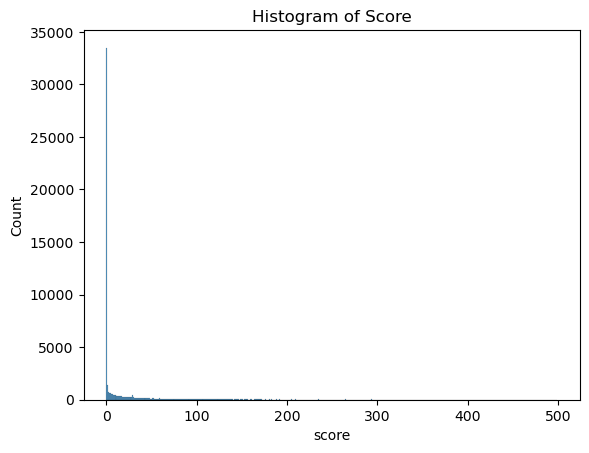

In [76]:
import seaborn as sns
sns.histplot(sampled_df['score'], kde=False)

# Display the histogram
plt.title('Histogram of Score')
plt.show()

In [ ]:
import seaborn as sns

sampled_df = sampled_df[sampled_df['num_comments'] < 200]

sns.histplot(sampled_df['num_comments'], kde=False)

# Display the histogram
plt.title('Histogram of Number of Comments')
plt.show()

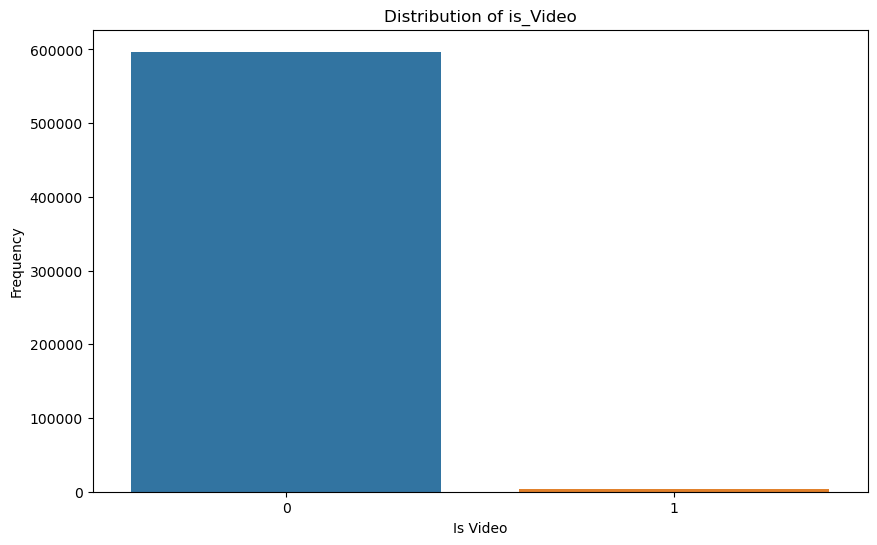

In [73]:
# Bar plot for is_video
is_video_counts = df_encoded_pd['is_video'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=is_video_counts.index, y=is_video_counts.values)
plt.title('Distribution of is_Video')
plt.xlabel('Is Video')
plt.ylabel('Frequency')
plt.show()


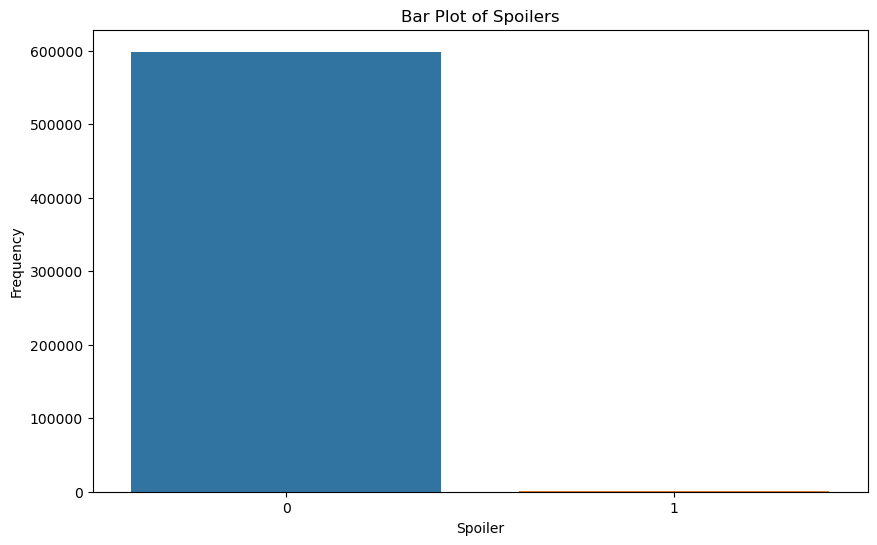

In [74]:
# Bar plot for spoiler
spoiler_counts = df_encoded_pd['spoiler'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=spoiler_counts.index, y=spoiler_counts.values)
plt.title('Distribution of Spoilers')
plt.xlabel('Spoiler')
plt.ylabel('Frequency')
plt.show()
